In [1]:
import torch.nn as nn
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dependency import *
from utils import get_parameter_number
from dataloader import *

In [2]:
# define model here
sigmoid = nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

#class ResNet-with-Uncertainty: derm
class Resnet_with_uncertainty_derm(nn.Module):
    def __init__(self,class_list):
        super().__init__()
        self.num_label = class_list[0]
        self.num_pn = class_list[1]
        self.num_str = class_list[2]
        self.num_pig = class_list[3]
        self.num_rs = class_list[4]
        self.num_dag = class_list[5]
        self.num_bwv = class_list[6]
        self.num_vs = class_list[7]
        self.num_uncertainty = class_list[8]
        self.dropout = nn.Dropout(0.8)

        self.model_clinic = torchvision.models.resnet50(pretrained=True)
        self.model_derm = torchvision.models.resnet50(pretrained=True)

        #define the clinic model
        self.conv1_cli = self.model_clinic.conv1
        self.bn1_cli = self.model_clinic.bn1
        self.relu_cli = self.model_clinic.relu
        self.maxpool_cli = self.model_clinic.maxpool
        self.layer1_cli = self.model_clinic.layer1
        self.layer2_cli = self.model_clinic.layer2
        self.layer3_cli = self.model_clinic.layer3
        self.layer4_cli = self.model_clinic.layer4
        self.avgpool_cli = self.model_clinic.avgpool

        #define the derm model
        self.conv1_derm = self.model_derm.conv1
        self.bn1_derm = self.model_derm.bn1
        self.relu_derm = self.model_derm.relu
        self.maxpool_derm = self.model_derm.maxpool
        self.layer1_derm = self.model_derm.layer1
        self.layer2_derm = self.model_derm.layer2
        self.layer3_derm = self.model_derm.layer3
        self.layer4_derm = self.model_derm.layer4
        self.avgpool_derm = self.model_derm.avgpool

        self.global_avg = nn.AdaptiveAvgPool2d((1,1))

        self.cli_mlp = nn.Sequential(
            nn.Linear(2048,512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.derm_mlp = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(2048*2,1024),
            nn.BatchNorm1d(1024),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(1024,256),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.fc_cli = nn.Linear(128, self.num_label)
        self.fc_pn_cli = nn.Linear(128, self.num_pn)
        self.fc_str_cli = nn.Linear(128, self.num_str)
        self.fc_pig_cli = nn.Linear(128, self.num_pig)
        self.fc_rs_cli = nn.Linear(128, self.num_rs)
        self.fc_dag_cli = nn.Linear(128, self.num_dag)
        self.fc_bwv_cli = nn.Linear(128, self.num_bwv)
        self.fc_vs_cli = nn.Linear(128, self.num_vs)
        self.fc_uncertainty_cli = nn.Linear(128,self.num_uncertainty)

        # self.fc_derm_ = nn.Linear(2048, 512)
        self.fc_derm = nn.Linear(128, self.num_label)
        self.fc_pn_derm = nn.Linear(128, self.num_pn)
        self.fc_str_derm = nn.Linear(128, self.num_str)
        self.fc_pig_derm = nn.Linear(128, self.num_pig)
        self.fc_rs_derm = nn.Linear(128, self.num_rs)
        self.fc_dag_derm = nn.Linear(128, self.num_dag)
        self.fc_bwv_derm = nn.Linear(128, self.num_bwv)
        self.fc_vs_derm = nn.Linear(128, self.num_vs)
        self.fc_uncertainty_derm = nn.Linear(128, self.num_uncertainty)

        self.fc = nn.Linear(128, self.num_label)
        self.fc_pn = nn.Linear(128, self.num_pn)
        self.fc_str = nn.Linear(128, self.num_str)
        self.fc_pig = nn.Linear(128, self.num_pig)
        self.fc_rs = nn.Linear(128, self.num_rs)
        self.fc_dag = nn.Linear(128, self.num_dag)
        self.fc_bwv = nn.Linear(128, self.num_bwv)
        self.fc_vs = nn.Linear(128, self.num_vs)
        self.fc_uncertainty = nn.Linear(128,self.num_uncertainty)
        
        self.gradients = None 
    
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self,x):
        x_derm = x

        x_derm = self.conv1_derm(x_derm)
        x_derm = self.bn1_derm(x_derm)
        x_derm = self.relu_derm(x_derm)
        x_derm = self.maxpool_derm(x_derm)
        x_derm = self.layer1_derm(x_derm)
        x_derm = self.layer2_derm(x_derm)
        x_derm = self.layer3_derm(x_derm)
        x_derm = self.layer4_derm(x_derm)
        
        #register a hook 
        h = x_derm.register_hook(self.activations_hook)
        x_derm = self.avgpool_derm(x_derm)

        x_derm = self.global_avg(x_derm)
        
        x_derm = x_derm.view(x.size(0),-1)
        x_derm = self.derm_mlp(x_derm)
        x_derm = self.dropout(x_derm)
        logit_derm = self.fc_derm(x_derm)
        logit_pn_derm = self.fc_pn_derm(x_derm)
        logit_str_derm = self.fc_str_derm(x_derm)
        logit_pig_derm = self.fc_pig_derm(x_derm)
        logit_rs_derm = self.fc_rs_derm(x_derm)
        logit_dag_derm = self.fc_dag_derm(x_derm)
        logit_bwv_derm = self.fc_bwv_derm(x_derm)
        logit_vs_derm = self.fc_vs_derm(x_derm)
        logit_uncertainty_derm = self.fc_uncertainty_derm(x_derm)

        return [(logit_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm)]
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self,x):
        x_derm = x

        x_derm = self.conv1_derm(x_derm)
        x_derm = self.bn1_derm(x_derm)
        x_derm = self.relu_derm(x_derm)
        x_derm = self.maxpool_derm(x_derm)
        x_derm = self.layer1_derm(x_derm)
        x_derm = self.layer2_derm(x_derm)
        x_derm = self.layer3_derm(x_derm)
        x_derm = self.layer4_derm(x_derm)

        return x_derm
    
    def criterion(self,logit,truth):
        loss = nn.CrossEntropyLoss()(logit,truth)
        return loss

    def criterion1(self,logit,truth):
        loss = nn.L1Loss()(logit,truth)
        return loss

    def criterion_MSE(self,logit,truth):
        logit = nn.Sigmoid()(logit)
        loss = nn.MSELoss()(logit,truth)
        return loss

    def metric(self, logit, truth):
        _, prediction = torch.max(logit.data, 1)
        acc = torch.sum(prediction == truth)
        return acc

    def set_mode(self, mode):
        self.mode = mode
        if mode in ["eval", "valid", "test"]:
            self.eval()
        elif mode in ["train"]:
            self.train()
        else:
            raise NotImplementedError
            
#ResNet-with-Uncertainty: clic
class Resnet_with_uncertainty_clic(nn.Module):
    def __init__(self,class_list):
        super().__init__()
        self.num_label = class_list[0]
        self.num_pn = class_list[1]
        self.num_str = class_list[2]
        self.num_pig = class_list[3]
        self.num_rs = class_list[4]
        self.num_dag = class_list[5]
        self.num_bwv = class_list[6]
        self.num_vs = class_list[7]
        self.num_uncertainty = class_list[8]
        self.dropout = nn.Dropout(0.8)

        self.model_clinic = torchvision.models.resnet50(pretrained=True)
        self.model_derm = torchvision.models.resnet50(pretrained=True)

        #define the clinic model
        self.conv1_cli = self.model_clinic.conv1
        self.bn1_cli = self.model_clinic.bn1
        self.relu_cli = self.model_clinic.relu
        self.maxpool_cli = self.model_clinic.maxpool
        self.layer1_cli = self.model_clinic.layer1
        self.layer2_cli = self.model_clinic.layer2
        self.layer3_cli = self.model_clinic.layer3
        self.layer4_cli = self.model_clinic.layer4
        self.avgpool_cli = self.model_clinic.avgpool

        #define the derm model
        self.conv1_derm = self.model_derm.conv1
        self.bn1_derm = self.model_derm.bn1
        self.relu_derm = self.model_derm.relu
        self.maxpool_derm = self.model_derm.maxpool
        self.layer1_derm = self.model_derm.layer1
        self.layer2_derm = self.model_derm.layer2
        self.layer3_derm = self.model_derm.layer3
        self.layer4_derm = self.model_derm.layer4
        self.avgpool_derm = self.model_derm.avgpool

        self.global_avg = nn.AdaptiveAvgPool2d((1,1))

        self.cli_mlp = nn.Sequential(
            nn.Linear(2048,512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.derm_mlp = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(2048*2,1024),
            nn.BatchNorm1d(1024),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(1024,256),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )
        self.fc_cli = nn.Linear(128, self.num_label)
        self.fc_pn_cli = nn.Linear(128, self.num_pn)
        self.fc_str_cli = nn.Linear(128, self.num_str)
        self.fc_pig_cli = nn.Linear(128, self.num_pig)
        self.fc_rs_cli = nn.Linear(128, self.num_rs)
        self.fc_dag_cli = nn.Linear(128, self.num_dag)
        self.fc_bwv_cli = nn.Linear(128, self.num_bwv)
        self.fc_vs_cli = nn.Linear(128, self.num_vs)
        self.fc_uncertainty_cli = nn.Linear(128,self.num_uncertainty)

        # self.fc_derm_ = nn.Linear(2048, 512)
        self.fc_derm = nn.Linear(128, self.num_label)
        self.fc_pn_derm = nn.Linear(128, self.num_pn)
        self.fc_str_derm = nn.Linear(128, self.num_str)
        self.fc_pig_derm = nn.Linear(128, self.num_pig)
        self.fc_rs_derm = nn.Linear(128, self.num_rs)
        self.fc_dag_derm = nn.Linear(128, self.num_dag)
        self.fc_bwv_derm = nn.Linear(128, self.num_bwv)
        self.fc_vs_derm = nn.Linear(128, self.num_vs)
        self.fc_uncertainty_derm = nn.Linear(128, self.num_uncertainty)

        self.fc = nn.Linear(128, self.num_label)
        self.fc_pn = nn.Linear(128, self.num_pn)
        self.fc_str = nn.Linear(128, self.num_str)
        self.fc_pig = nn.Linear(128, self.num_pig)
        self.fc_rs = nn.Linear(128, self.num_rs)
        self.fc_dag = nn.Linear(128, self.num_dag)
        self.fc_bwv = nn.Linear(128, self.num_bwv)
        self.fc_vs = nn.Linear(128, self.num_vs)
        self.fc_uncertainty = nn.Linear(128,self.num_uncertainty)
        
        self.gradients = None 
    
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self,x):
        x_clic = x
        x_clic = self.conv1_cli(x_clic)
        x_clic = self.bn1_cli(x_clic)
        x_clic = self.relu_cli(x_clic)
        x_clic = self.maxpool_cli(x_clic)
        x_clic = self.layer1_cli(x_clic)
        x_clic = self.layer2_cli(x_clic)
        x_clic = self.layer3_cli(x_clic)
        x_clic = self.layer4_cli(x_clic)
        
        #register hook
        h = x_clic.register_hook(self.activations_hook)
        
        x_clic = self.avgpool_cli(x_clic)

        x_clic = self.global_avg(x_clic)

        x_clic = x_clic.view(x_clic.size(0),-1)
        x_clic = self.cli_mlp(x_clic)
        x_clic = self.dropout(x_clic)
        logit_clic = self.fc_cli(x_clic)
        logit_pn_clic = self.fc_pn_cli(x_clic)
        logit_str_clic = self.fc_str_cli(x_clic)
        logit_pig_clic = self.fc_pig_cli(x_clic)
        logit_rs_clic = self.fc_rs_cli(x_clic)
        logit_dag_clic = self.fc_dag_cli(x_clic)
        logit_bwv_clic = self.fc_bwv_cli(x_clic)
        logit_vs_clic = self.fc_vs_cli(x_clic)
        logit_uncertainty_clic = self.fc_uncertainty_cli(x_clic)

        return [(logit_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic)]

    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        x_clic = x
        x_clic = self.conv1_cli(x_clic)
        x_clic = self.bn1_cli(x_clic)
        x_clic = self.relu_cli(x_clic)
        x_clic = self.maxpool_cli(x_clic)
        x_clic = self.layer1_cli(x_clic)
        x_clic = self.layer2_cli(x_clic)
        x_clic = self.layer3_cli(x_clic)
        x_clic = self.layer4_cli(x_clic)
        return x_clic
    
    def criterion(self,logit,truth):
        loss = nn.CrossEntropyLoss()(logit,truth)
        return loss

    def criterion1(self,logit,truth):
        loss = nn.L1Loss()(logit,truth)
        return loss

    def criterion_MSE(self,logit,truth):
        logit = nn.Sigmoid()(logit)
        loss = nn.MSELoss()(logit,truth)
        return loss

    def metric(self, logit, truth):
        _, prediction = torch.max(logit.data, 1)
        acc = torch.sum(prediction == truth)
        return acc

    def set_mode(self, mode):
        self.mode = mode
        if mode in ["eval", "valid", "test"]:
            self.eval()
        elif mode in ["train"]:
            self.train()
        else:
            raise NotImplementedError
            
            
class Resnet_with_uncertainty(nn.Module):
    def __init__(self,class_list):
        super().__init__()
        self.num_label = class_list[0]
        self.num_pn = class_list[1]
        self.num_str = class_list[2]
        self.num_pig = class_list[3]
        self.num_rs = class_list[4]
        self.num_dag = class_list[5]
        self.num_bwv = class_list[6]
        self.num_vs = class_list[7]
        self.num_uncertainty = class_list[8]
        self.dropout = nn.Dropout(0.8)

        self.model_clinic = torchvision.models.resnet50(pretrained=True)
        self.model_derm = torchvision.models.resnet50(pretrained=True)

        #define the clinic model
        self.conv1_cli = self.model_clinic.conv1
        self.bn1_cli = self.model_clinic.bn1
        self.relu_cli = self.model_clinic.relu
        self.maxpool_cli = self.model_clinic.maxpool
        self.layer1_cli = self.model_clinic.layer1
        self.layer2_cli = self.model_clinic.layer2
        self.layer3_cli = self.model_clinic.layer3
        self.layer4_cli = self.model_clinic.layer4
        self.avgpool_cli = self.model_clinic.avgpool

        #define the derm model
        self.conv1_derm = self.model_derm.conv1
        self.bn1_derm = self.model_derm.bn1
        self.relu_derm = self.model_derm.relu
        self.maxpool_derm = self.model_derm.maxpool
        self.layer1_derm = self.model_derm.layer1
        self.layer2_derm = self.model_derm.layer2
        self.layer3_derm = self.model_derm.layer3
        self.layer4_derm = self.model_derm.layer4
        self.avgpool_derm = self.model_derm.avgpool

        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
        self.cli_mlp = nn.Sequential(
            nn.Linear(2048,512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.derm_mlp = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(2048*2,1024),
            nn.BatchNorm1d(1024),
            Swish_Module(),
            nn.Dropout(0.8),
            nn.Linear(1024,256),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            Swish_Module(),
        )
        self.fc_cli = nn.Linear(128, self.num_label)
        self.fc_pn_cli = nn.Linear(128, self.num_pn)
        self.fc_str_cli = nn.Linear(128, self.num_str)
        self.fc_pig_cli = nn.Linear(128, self.num_pig)
        self.fc_rs_cli = nn.Linear(128, self.num_rs)
        self.fc_dag_cli = nn.Linear(128, self.num_dag)
        self.fc_bwv_cli = nn.Linear(128, self.num_bwv)
        self.fc_vs_cli = nn.Linear(128, self.num_vs)
        self.fc_uncertainty_cli = nn.Linear(128,self.num_uncertainty)

        # self.fc_derm_ = nn.Linear(2048, 512)
        self.fc_derm = nn.Linear(128, self.num_label)
        self.fc_pn_derm = nn.Linear(128, self.num_pn)
        self.fc_str_derm = nn.Linear(128, self.num_str)
        self.fc_pig_derm = nn.Linear(128, self.num_pig)
        self.fc_rs_derm = nn.Linear(128, self.num_rs)
        self.fc_dag_derm = nn.Linear(128, self.num_dag)
        self.fc_bwv_derm = nn.Linear(128, self.num_bwv)
        self.fc_vs_derm = nn.Linear(128, self.num_vs)
        self.fc_uncertainty_derm = nn.Linear(128, self.num_uncertainty)

        self.fc = nn.Linear(128, self.num_label)
        self.fc_pn = nn.Linear(128, self.num_pn)
        self.fc_str = nn.Linear(128, self.num_str)
        self.fc_pig = nn.Linear(128, self.num_pig)
        self.fc_rs = nn.Linear(128, self.num_rs)
        self.fc_dag = nn.Linear(128, self.num_dag)
        self.fc_bwv = nn.Linear(128, self.num_bwv)
        self.fc_vs = nn.Linear(128, self.num_vs)
        self.fc_uncertainty = nn.Linear(128,self.num_uncertainty)
        
        self.gradients_derm = None
        self.gradients_clic = None
    
    def activations_hook_derm(self,grad):
        self.gradients_derm = grad
    
    def activations_hook_clic(self,grad):
        self.gradients_clic = grad

    def forward(self,x):
        (x_clic,x_derm) = x
        x_clic = self.conv1_cli(x_clic)
        x_clic = self.bn1_cli(x_clic)
        x_clic = self.relu_cli(x_clic)
        x_clic = self.maxpool_cli(x_clic)
        x_clic = self.layer1_cli(x_clic)
        x_clic = self.layer2_cli(x_clic)
        x_clic = self.layer3_cli(x_clic)
        x_clic = self.layer4_cli(x_clic)
        #clic register hook here 
        h_clic = x_clic.register_hook(self.activations_hook_clic)
        
        
        x_clic = self.avgpool_cli(x_clic)
        
        x_derm = self.conv1_derm(x_derm)
        x_derm = self.bn1_derm(x_derm)
        x_derm = self.relu_derm(x_derm)
        x_derm = self.maxpool_derm(x_derm)
        x_derm = self.layer1_derm(x_derm)
        x_derm = self.layer2_derm(x_derm)
        x_derm = self.layer3_derm(x_derm)
        x_derm = self.layer4_derm(x_derm)
        #derm register hook here
        h_derm = x_derm.register_hook(self.activations_hook_derm)
        
        x_derm = self.avgpool_derm(x_derm)

        x_clic = self.global_avg(x_clic)
        x_derm = self.global_avg(x_derm)
        
        x = torch.cat((x_clic,x_derm),1)
        x = x.view(x.size(0),-1)

        x_clic = x_clic.view(x_clic.size(0),-1)
        x_clic_coss = x_clic
        
        x_clic = self.cli_mlp(x_clic)
        x_clic = self.dropout(x_clic)
        logit_clic = self.fc_cli(x_clic)
        logit_pn_clic = self.fc_pn_cli(x_clic)
        logit_str_clic = self.fc_str_cli(x_clic)
        logit_pig_clic = self.fc_pig_cli(x_clic)
        logit_rs_clic = self.fc_rs_cli(x_clic)
        logit_dag_clic = self.fc_dag_cli(x_clic)
        logit_bwv_clic = self.fc_bwv_cli(x_clic)
        logit_vs_clic = self.fc_vs_cli(x_clic)
        logit_uncertainty_clic = self.fc_uncertainty_cli(x_clic)

        x_derm = x_derm.view(x.size(0),-1)
        x_derm_coss = x_derm
        x_derm = self.derm_mlp(x_derm)
        x_derm = self.dropout(x_derm)
        logit_derm = self.fc_derm(x_derm)
        logit_pn_derm = self.fc_pn_derm(x_derm)
        logit_str_derm = self.fc_str_derm(x_derm)
        logit_pig_derm = self.fc_pig_derm(x_derm)
        logit_rs_derm = self.fc_rs_derm(x_derm)
        logit_dag_derm = self.fc_dag_derm(x_derm)
        logit_bwv_derm = self.fc_bwv_derm(x_derm)
        logit_vs_derm = self.fc_vs_derm(x_derm)
        logit_uncertainty_derm = self.fc_uncertainty_derm(x_derm)


        x = self.mlp(x)
        x = self.dropout(x)
        logit_x = self.fc(x)
        logit_pn_x = self.fc_pn(x)
        logit_str_x = self.fc_str(x)
        logit_pig_x = self.fc_pig(x)
        logit_rs_x = self.fc_rs(x)
        logit_dag_x = self.fc_dag(x)
        logit_bwv_x = self.fc_bwv(x)
        logit_vs_x = self.fc_vs(x)
        logit_uncertainty_x = self.fc_uncertainty(x)

        return [(logit_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
                (logit_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
                (logit_x,logit_pn_x,logit_str_x,logit_pig_x,logit_rs_x,logit_dag_x,logit_bwv_x,logit_vs_x,logit_uncertainty_x),
                (x_clic_coss,x_derm_coss)]
    
    def get_activations_gradient_clic(self):
        return self.gradients_clic
    
    def get_activations_gradient_derm(self):
        return self.gradients_derm
    
    def get_channels(self, x):
        (x_clic,x_derm) = x
        x_clic = self.conv1_cli(x_clic)
        x_clic = self.bn1_cli(x_clic)
        x_clic = self.relu_cli(x_clic)
        x_clic = self.maxpool_cli(x_clic)
        x_clic = self.layer1_cli(x_clic)
        x_clic = self.layer2_cli(x_clic)
        x_clic = self.layer3_cli(x_clic)
        x_clic = self.layer4_cli(x_clic)
        
        batch_size_1, channels_1, height_1, width_1 = x_clic.size()
        print("channels_1:", channels_1)
        x_clic = self.avgpool_cli(x_clic)
        
        x_derm = self.conv1_derm(x_derm)
        x_derm = self.bn1_derm(x_derm)
        x_derm = self.relu_derm(x_derm)
        x_derm = self.maxpool_derm(x_derm)
        x_derm = self.layer1_derm(x_derm)
        x_derm = self.layer2_derm(x_derm)
        x_derm = self.layer3_derm(x_derm)
        x_derm = self.layer4_derm(x_derm)
        
        x_derm = self.avgpool_derm(x_derm)
        
        batch_size_2, channels_2, height_2, width_2 = x_clic.size()
        print("channels_2:",channels_2)
        x_clic = self.global_avg(x_clic)
        x_derm = self.global_avg(x_derm)
        
        x = torch.cat((x_clic,x_derm),1)
        return channels_1, channels_2
    
    def get_activations_clic(self, x):
        (x_clic,x_derm) = x
        x_clic = self.conv1_cli(x_clic)
        x_clic = self.bn1_cli(x_clic)
        x_clic = self.relu_cli(x_clic)
        x_clic = self.maxpool_cli(x_clic)
        x_clic = self.layer1_cli(x_clic)
        x_clic = self.layer2_cli(x_clic)
        x_clic = self.layer3_cli(x_clic)
        x_clic = self.layer4_cli(x_clic)
        return x_clic
    
    def get_activations_derm(self, x):
        (x_clic,x_derm) = x
        x_derm = self.conv1_derm(x_derm)
        x_derm = self.bn1_derm(x_derm)
        x_derm = self.relu_derm(x_derm)
        x_derm = self.maxpool_derm(x_derm)
        x_derm = self.layer1_derm(x_derm)
        x_derm = self.layer2_derm(x_derm)
        x_derm = self.layer3_derm(x_derm)
        x_derm = self.layer4_derm(x_derm)
        return x_derm
    
    
    def criterion(self,logit,truth):
        loss = nn.CrossEntropyLoss()(logit,truth)
        return loss

    def criterion1(self,logit,truth):
        loss = nn.L1Loss()(logit,truth)
        return loss

    def criterion_MSE(self,logit,truth):
        logit = nn.Sigmoid()(logit)
        loss = nn.MSELoss()(logit,truth)
        return loss

    def metric(self, logit, truth):
        _, prediction = torch.max(logit.data, 1)
        acc = torch.sum(prediction == truth)
        return acc

    def set_mode(self, mode):
        self.mode = mode
        if mode in ["eval", "valid", "test"]:
            self.eval()
        elif mode in ["train"]:
            self.train()
        else:
            raise NotImplementedError

# -----------load images------------

In [11]:
'''Nil076.jpg, Nil090.jpg, FCL054.jpg, Fcl092.jpg, Ffl042.jpg, Fll126.jpg, Ffl083.jpg'''
#load the test images ----clic
img_path1 = './release_v0/release_v0/images/Fll/Fll126.jpg'#derm
img_path2 = './release_v0/release_v0/images/Fll/Fll125.jpg'#clic
shape = (229, 229)
img1 = load_image(img_path1,shape = shape)
img2 = load_image(img_path2,shape = shape)

img1 = torch.from_numpy(np.transpose(img1,(2,0,1)).astype('float32') / 255).cuda()
img2 = torch.from_numpy(np.transpose(img2, (2,0,1)).astype('float32') / 255).cuda()

img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)

print("img1 shape:", img1.shape)
print("img2 shape:", img2.shape)

img1 shape: torch.Size([1, 3, 229, 229])
img2 shape: torch.Size([1, 3, 229, 229])


# multi-model on Derm images

In [12]:
multi_model = Resnet_with_uncertainty(class_list).cuda()
weight_file = './multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth'
print(weight_file)
multi_model.load_state_dict(torch.load(weight_file))
multi_model.set_mode('eval')

./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth


im_predict_prob: tensor([[0.0731, 0.0936, 0.7119, 0.0621, 0.0593]], grad_fn=<SoftmaxBackward>)
channels_1: 2048
channels_2: 2048
heatmap.shape: (8, 8)
------------View Heat-map----------------


E:\miniconda3\envs\pytorch1.8.1\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


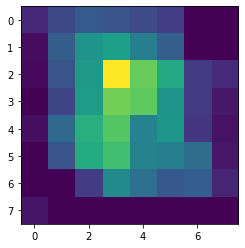

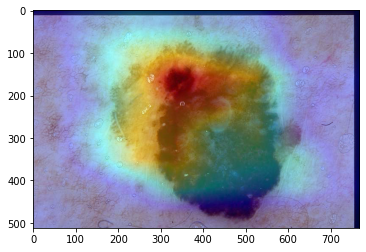

In [13]:
[(logit_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
                (logit_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
                (logit_x,logit_pn_x,logit_str_x,logit_pig_x,logit_rs_x,logit_dag_x,logit_bwv_x,logit_vs_x,logit_uncertainty_x),
                (x_clic_coss,x_derm_coss)] = multi_model((img2,img1))

im_predict = logit_x.cpu()
#predict top-5
softmax = nn.Softmax(dim=1)
im_predict_prob = softmax(im_predict)
print("im_predict_prob:",im_predict_prob)
prob,prelab = torch.topk(im_predict_prob,4)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()

im_predict[:,prelab[0]].backward()

#Get the gradient of the model
gradients = multi_model.get_activations_gradient_derm()

#Calculate the mean of the channels corresponding to the gradient
mean_gradients = torch.mean(gradients, dim=[0, 2, 3])

#print channels 
multi_model.get_channels((img2,img1))
#The convolutional features of the image output in the corresponding convolutional layer are obtained
activations = multi_model.get_activations_derm((img2,img1)).detach()

#Multiply each channel by the corresponding gradient mean
for i in range(len(mean_gradients)):
    activations[:,i,:,:] *= mean_gradients[i]

#The average output of all channels is calculated to obtain a heat map
heatmap = torch.mean(activations,dim=1).squeeze()

#The relu function is applied to the heat map
heatmap = F.relu(heatmap).cpu()

#Heat map standardization
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()

print("heatmap.shape:",heatmap.shape)
#view
plt.imshow(heatmap)


#Fusing the heat map onto the image
img = cv2.imread(img_path1)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
Grad_cam_img = heatmap * 0.6 + img
Grad_cam_img = Grad_cam_img / Grad_cam_img.max()

#view
b,g,r = cv2.split(Grad_cam_img)
Grad_cam_img = cv2.merge([r,g,b])
plt.figure()
print("------------View Heat-map----------------")
plt.imshow(Grad_cam_img)
plt.show()

# multi-model on clinic image

E:\miniconda3\envs\pytorch1.8.1\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


heatmap.shape: (8, 8)
------------View Heat-map----------------


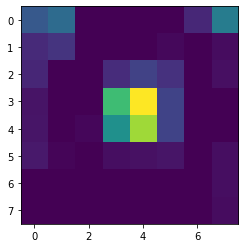

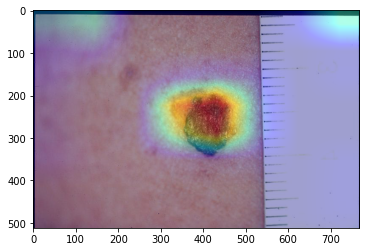

In [14]:
[(logit_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
                (logit_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
                (logit_x,logit_pn_x,logit_str_x,logit_pig_x,logit_rs_x,logit_dag_x,logit_bwv_x,logit_vs_x,logit_uncertainty_x),
                (x_clic_coss,x_derm_coss)] = multi_model((img2,img1))

im_predict = logit_x.cpu()
#predict top-5
softmax = nn.Softmax(dim=1)
im_predict_prob = softmax(im_predict)
prob,prelab = torch.topk(im_predict_prob,4)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()

im_predict[:,prelab[0]].backward()

#Get the gradient of the model
gradients = multi_model.get_activations_gradient_clic()

#Calculate the mean of the channels corresponding to the gradient
mean_gradients = torch.mean(gradients, dim=[0, 2, 3])

#The convolutional features of the image output in the corresponding convolutional layer are obtained
activations = multi_model.get_activations_clic((img2,img1)).detach()

#Multiply each channel by the corresponding gradient mean
for i in range(len(mean_gradients)):
    activations[:,i,:,:] *= mean_gradients[i]

#The average output of all channels is calculated to obtain a heat map
heatmap = torch.mean(activations,dim=1).squeeze()

#The relu function is applied to the heat map
heatmap = F.relu(heatmap).cpu()

#Heat map standardization
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()

print("heatmap.shape:",heatmap.shape)
#view
plt.imshow(heatmap)


#Fusing the heat map onto the image
img = cv2.imread(img_path2)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
Grad_cam_img = heatmap * 0.6 + img
Grad_cam_img = Grad_cam_img / Grad_cam_img.max()

#view
b,g,r = cv2.split(Grad_cam_img)
Grad_cam_img = cv2.merge([r,g,b])
plt.figure()
print("------------View Heat-map----------------")
plt.imshow(Grad_cam_img)
plt.show()

# Clic-model on Clic images

In [15]:
model_clic = Resnet_with_uncertainty_clic(class_list).cuda()
weight_file = './multimodal_Resnet_clinic_Normal_weight_file/3/checkpoint/best_mean_acc_model.pth'
print(weight_file)
model_clic.load_state_dict(torch.load(weight_file))
model_clic.set_mode('eval')

./multimodal_Resnet_clinic_Normal_weight_file/3/checkpoint/best_mean_acc_model.pth


E:\miniconda3\envs\pytorch1.8.1\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


heatmap.shape: (8, 8)
------------View Heat-map----------------


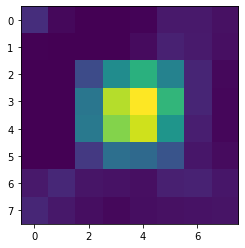

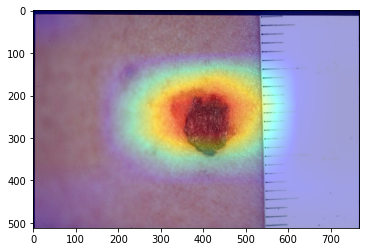

In [16]:
img = img2
[(logit_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic)] = model_clic(img2)

im_predict = logit_clic.cpu()
#predict top-5
softmax = nn.Softmax(dim=1)
im_predict_prob = softmax(im_predict)
prob,prelab = torch.topk(im_predict_prob,4)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()

im_predict[:,prelab[0]].backward()

#Get the gradient of the model
gradients = model_clic.get_activations_gradient()

#Calculate the mean of the channels corresponding to the gradient
mean_gradients = torch.mean(gradients, dim=[0, 2, 3])

#The convolutional features of the image output in the corresponding convolutional layer are obtained
activations = model_clic.get_activations(img).detach()

#Multiply each channel by the corresponding gradient mean
for i in range(len(mean_gradients)):
    activations[:,i,:,:] *= mean_gradients[i]

#The average output of all channels is calculated to obtain a heat map
heatmap = torch.mean(activations,dim=1).squeeze()

#The relu function is applied to the heat map
heatmap = F.relu(heatmap).cpu()

#Heat map standardization
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()

print("heatmap.shape:",heatmap.shape)
#view
plt.imshow(heatmap)


#Fusing the heat map onto the image
img = cv2.imread(img_path2)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
Grad_cam_img = heatmap * 0.6 + img
Grad_cam_img = Grad_cam_img / Grad_cam_img.max()

#view
b,g,r = cv2.split(Grad_cam_img)
Grad_cam_img = cv2.merge([r,g,b])
plt.figure()
print("------------View Heat-map----------------")
plt.imshow(Grad_cam_img)
plt.show()

# Derm-model on Derm images

In [17]:
model_derm = Resnet_with_uncertainty_derm(class_list).cuda()
weight_file = './multimodal_Resnet_derm_Normal_weight_file/1/checkpoint/best_mean_acc_model.pth'
print(weight_file)
model_derm.load_state_dict(torch.load(weight_file))
model_derm.set_mode('eval')

./multimodal_Resnet_derm_Normal_weight_file/1/checkpoint/best_mean_acc_model.pth


E:\miniconda3\envs\pytorch1.8.1\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


mean_gradients: tensor([-6.4499e-05,  2.9734e-05,  1.3276e-04,  ...,  1.2605e-04,
        -7.7001e-05, -7.1716e-07], device='cuda:0')
mean_gradients.shape: torch.Size([2048])
activations.shape: torch.Size([1, 2048, 8, 8])
heatmap: tensor([[6.7463e-06, 5.9328e-06, 4.8460e-06, 6.7245e-06, 4.7366e-06, 1.8326e-06,
         4.3268e-06, 6.0086e-06],
        [6.4526e-06, 1.0094e-05, 3.1855e-05, 4.2884e-05, 4.3897e-05, 1.8071e-05,
         4.3809e-06, 4.0984e-06],
        [4.9173e-06, 1.4113e-05, 4.8980e-05, 7.3788e-05, 7.4942e-05, 4.1674e-05,
         1.4893e-05, 2.2911e-06],
        [3.7350e-06, 1.1390e-05, 5.1651e-05, 6.3881e-05, 8.1917e-05, 5.1698e-05,
         2.4053e-05, 2.3772e-06],
        [3.1874e-06, 1.1816e-05, 3.8799e-05, 4.1818e-05, 5.2521e-05, 3.6339e-05,
         1.9179e-05, 2.4474e-06],
        [1.7572e-06, 1.0133e-05, 3.6259e-05, 5.0238e-05, 5.7686e-05, 3.7912e-05,
         1.6106e-05, 2.2934e-06],
        [1.3398e-06, 3.9300e-06, 1.5357e-05, 3.7710e-05, 4.9440e-05, 3.0380e-05

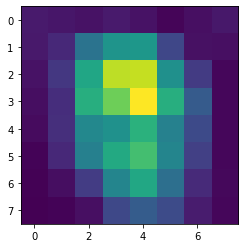

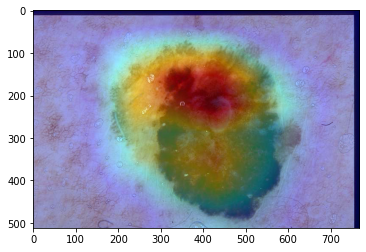

In [18]:
img = img1
[(logit_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm)] = model_derm(img1)

im_predict = logit_derm.cpu()
#predict top-5
softmax = nn.Softmax(dim=1)
im_predict_prob = softmax(im_predict)
prob,prelab = torch.topk(im_predict_prob,4)
prob = prob.data.numpy().flatten()
prelab = prelab.numpy().flatten()

im_predict[:,prelab[0]].backward()

#Get the gradient of the model
gradients = model_derm.get_activations_gradient()

#Calculate the mean of the channels corresponding to the gradient
mean_gradients = torch.mean(gradients, dim=[0, 2, 3])

print("mean_gradients:",mean_gradients)
print("mean_gradients.shape:",mean_gradients.shape)
#The convolutional features of the image output in the corresponding convolutional layer are obtained
activations = model_derm.get_activations(img).detach()
print("activations.shape:",activations.shape)

#Multiply each channel by the corresponding gradient mean
for i in range(len(mean_gradients)):
    activations[:,i,:,:] *= mean_gradients[i]

#The average output of all channels is calculated to obtain a heat map
heatmap = torch.mean(activations,dim=1).squeeze()
print("heatmap:",heatmap)

#The relu function is applied to the heat map
heatmap = F.relu(heatmap).cpu()

#Heat map standardization
heatmap /= torch.max(heatmap)
heatmap = heatmap.numpy()

print("heatmap.shape:",heatmap.shape)
#view
plt.imshow(heatmap)


#Fusing the heat map onto the image
img = cv2.imread(img_path1)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
Grad_cam_img = heatmap * 0.6 + img
Grad_cam_img = Grad_cam_img / Grad_cam_img.max()

#view
b,g,r = cv2.split(Grad_cam_img)
Grad_cam_img = cv2.merge([r,g,b])
plt.figure()
print("------------View Heat-map----------------")
plt.imshow(Grad_cam_img)
plt.show()